# Ross Sea synthetic model

import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

# local python scripts
from RIS_gravity_inversion import plotting, optimization, synthetic
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import pygmt
import copy
import harmonica as hm

# for plotting
import pvxarray
import matplotlib.pyplot as plt
import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# hvplot.extension('bokeh', 'matplotlib', 'plotly')
import panel.widgets as pnw
import panel as pn

pn.extension(comms="vscode")

import os

# Synthetic layers

This notebook creates a simple synthetic earth model comprised of 3 topography layers, Layer1, Layer2 and Layer3, representing the ice surface, icebase, and a crustal density contrast, respectively. We will compute the forward gravity of these 3 density contrasts. We will then create a low resolution version of Layer 2, to representing having limited knowledge of the ice-bed interface. We will then attempt to recover the full resolution Layer 2 in a gravity inversion (see `synthetic_inversion_simple_with_regional.ipynb`). The forward gravity of the full resolution layers will be used in the inversion, representing a perfect gravity survey, but the inversion will need to seperate out the regional field created by Layer3.

The layers are created with a series of 2D gaussian function of various wavelengths and amplitudes. 

## Set region and parameters

In [2]:
# set grid parameters
layer_spacing = 5e3
registration = "g"
reference = "ellipsoid"

# set gravity observation parameters
grav_observation_height = 1e3
sampled_grav_spacing = 20e3
airborne_grav_spacing = 1e3

In [3]:
inversion_region = utils.alter_region(regions.ross_sea, zoom=200e3)[0]

buffer_region = utils.alter_region(
    inversion_region,
    buffer=0,
)[1]

print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

inversion region =  [-300000.0, 250000.0, -1900000.0, -1500000.0]
buffer region =  [-300000, 250000, -1900000, -1500000]


In [4]:
x_cells = int(abs(buffer_region[0] - buffer_region[1]) / layer_spacing)
y_cells = int(abs(buffer_region[2] - buffer_region[3]) / layer_spacing)
prisms_per_layer = x_cells * y_cells
print(f"x axis prisms: {x_cells}")
print(f"y axis prisms: {y_cells}")
print(f"prisms per layer: {prisms_per_layer}")
print(f"total number of prisms: {prisms_per_layer * 3}")

x axis prisms: 110
y axis prisms: 80
prisms per layer: 8800
total number of prisms: 26400


## Surface

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


converting to be referenced to the WGS84 ellipsoid
spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


grid info (5000.0, [-300000.0, 250000.0, -1900000.0, -1500000.0], -65.658416748, -55.9449195862, 'g')
grid median value: -60.435448


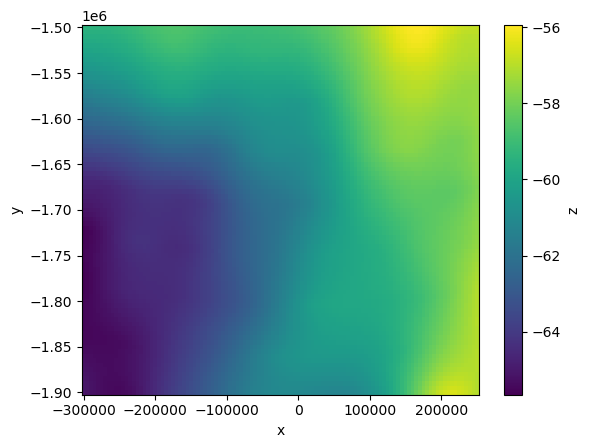

In [8]:
surface = fetch.bedmap2(
    layer="surface",
    reference=reference,
    region=buffer_region,
    spacing=layer_spacing,
    registration=registration,
    fill_nans=True,
)

surface.plot()
print("grid info", utils.get_grid_info(surface))
print("grid median value:", np.median(surface.values))

## Bathymetry

converting to be referenced to the WGS84 ellipsoid
spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


grid info (5000.0, [-300000.0, 250000.0, -1900000.0, -1500000.0], -4115.15136719, -267.01361084, 'g')
grid median value: -616.31854


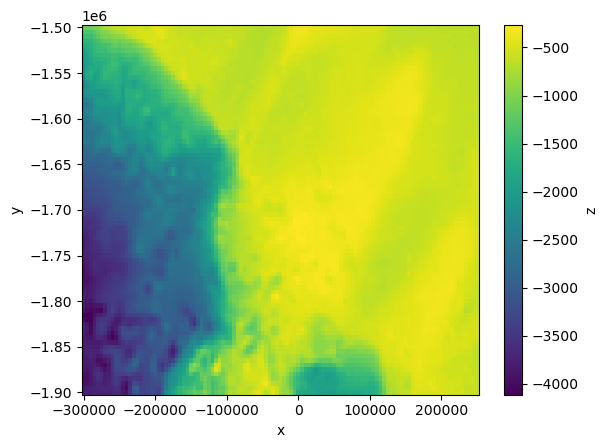

In [9]:
bed = fetch.bedmap2(
    layer="bed",
    reference=reference,
    region=buffer_region,
    spacing=layer_spacing,
    registration=registration,
)

bed.plot()
print("grid info", utils.get_grid_info(bed))
print("grid median value:", np.median(bed.values))

## Basement

returning grid with new region and/or registration, same spacing
grid info (5000.0, [-300000.0, 250000.0, -1900000.0, -1500000.0], -8271.14160156, -841.826843262, 'g')
grid median value: -3386.6501


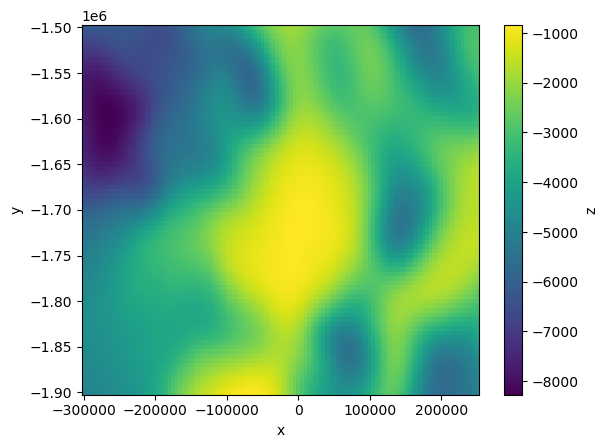

In [10]:
basement = fetch.basement(
    region=buffer_region,
    spacing=layer_spacing,
    registration=registration,
)
basement.plot()

print("grid info", utils.get_grid_info(basement))
print("grid median value:", np.median(basement.values))

## save to .zarr files

In [11]:
# use conventional coordinate names
surface = surface.rename({"x": "easting", "y": "northing"})
bed = bed.rename({"x": "easting", "y": "northing"})
basement = basement.rename({"x": "easting", "y": "northing"})

In [12]:
output = surface.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/Ross_Sea_surface.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

output = bed.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/Ross_Sea_bed.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

output = basement.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/Ross_Sea_basement.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

## load .zarr files

In [5]:
surface = xr.open_zarr("../synthetic_data/Ross_Sea_surface.zarr").z

bed = xr.open_zarr("../synthetic_data/Ross_Sea_bed.zarr").z

basement = xr.open_zarr("../synthetic_data/Ross_Sea_basement.zarr").z

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## vizualize

returning original grid
returning original grid
returning original grid


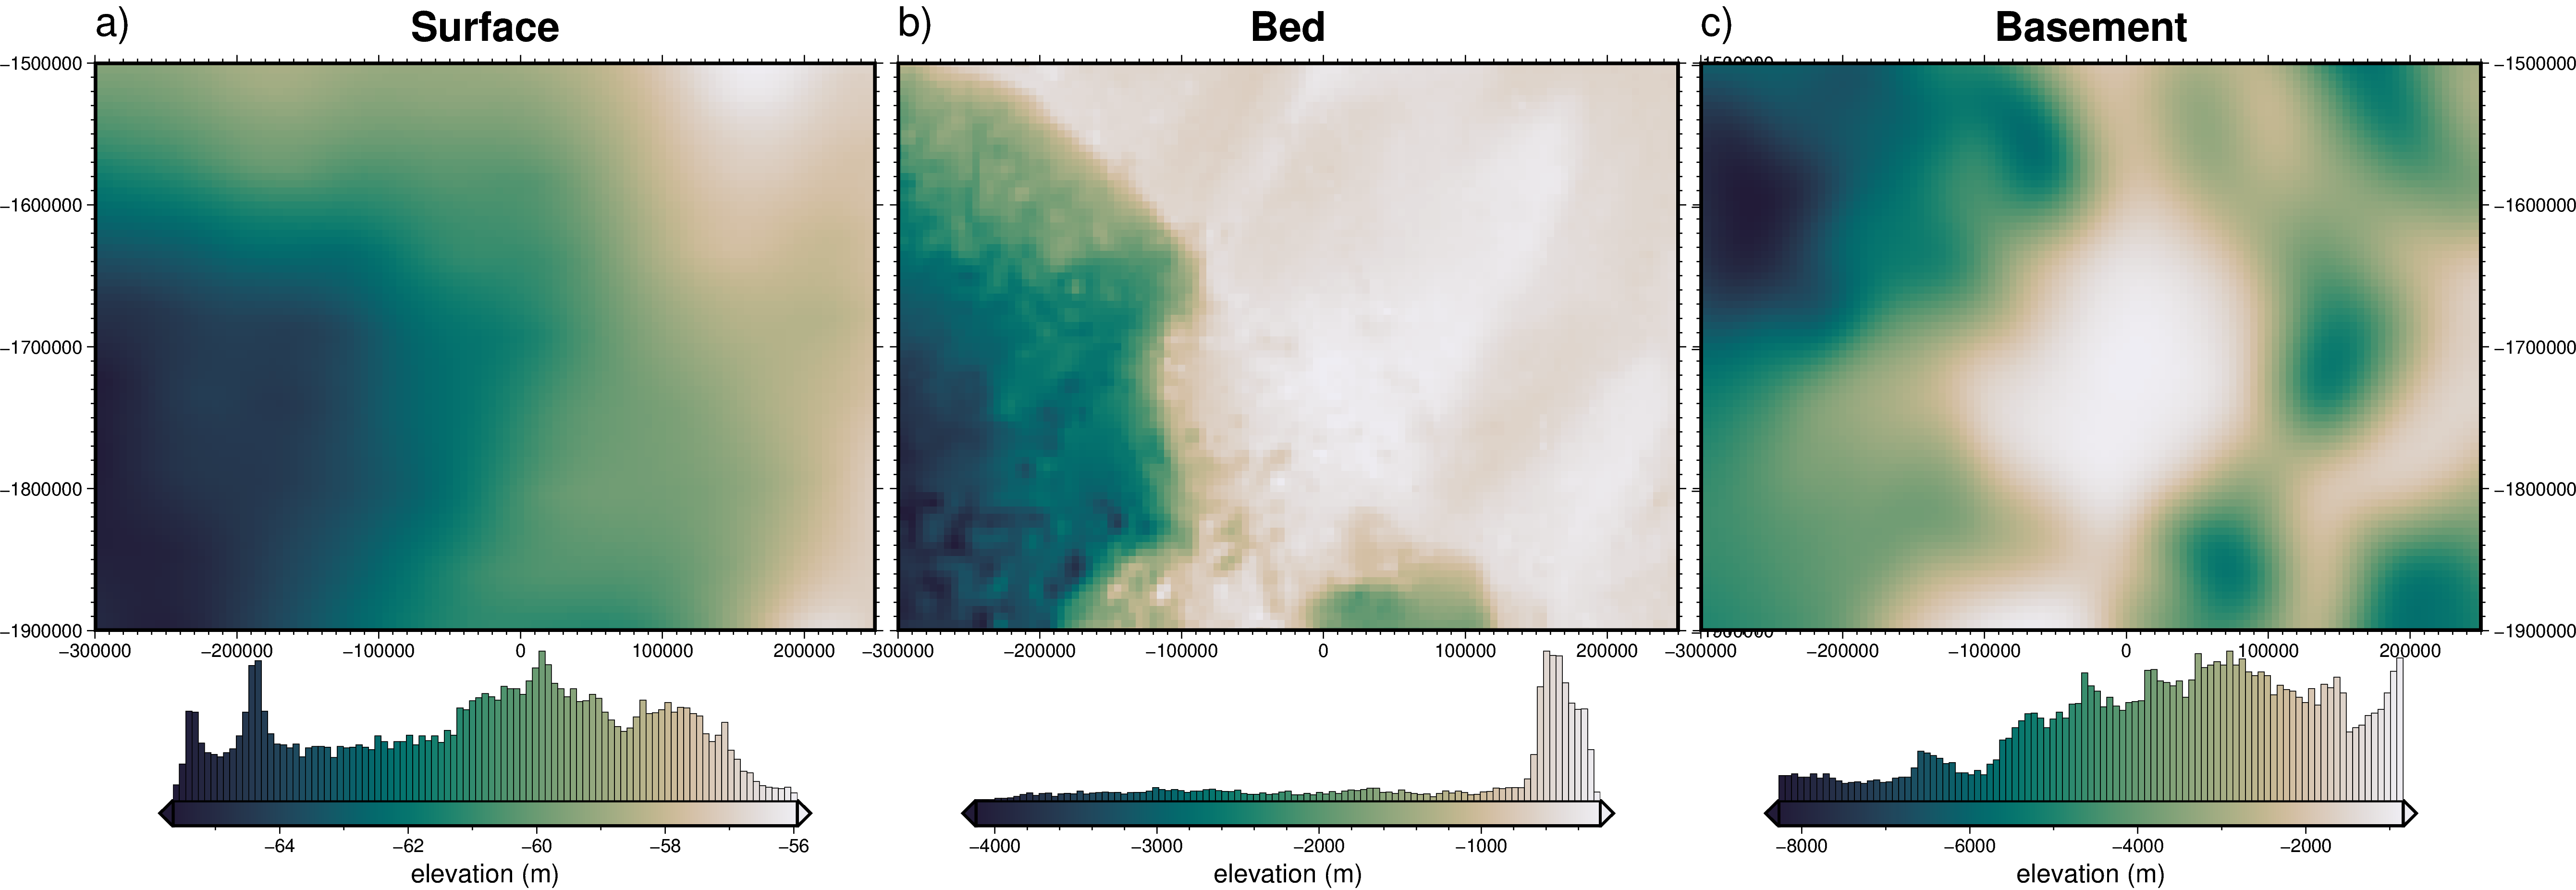

In [14]:
fig = maps.plot_grd(
    surface,
    fig_height=10,
    title="Surface",
    hist=True,
    cbar_yoffset=3,
    grd2_cpt=True,
    cmap="rain",
    reverse_cpt=True,
    cbar_label="elevation (m)",
    frame=["nSWe", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig.text(
    position="TL",
    text="a)",
    fill="white",
    font="20p,Helvetica,black",
    offset="j0/-1",
    clearance="+tO",
    no_clip=True,
)

fig = maps.plot_grd(
    bed,
    fig_height=10,
    title="Bed",
    hist=True,
    cbar_yoffset=3,
    grd2_cpt=True,
    cmap="rain",
    reverse_cpt=True,
    cbar_label="elevation (m)",
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
    fig=fig,
    origin_shift="xshift",
)

fig.text(
    position="TL",
    text="b)",
    fill="white",
    font="20p,Helvetica,black",
    offset="j0/-1",
    clearance="+tO",
    no_clip=True,
)

fig = maps.plot_grd(
    basement,
    fig_height=10,
    title="Basement",
    hist=True,
    cbar_yoffset=3,
    grd2_cpt=True,
    cmap="rain",
    reverse_cpt=True,
    cbar_label="elevation (m)",
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
    fig=fig,
    origin_shift="xshift",
)

fig.text(
    position="TL",
    text="c)",
    fill="white",
    font="20p,Helvetica,black",
    offset="j0/-1",
    clearance="+tO",
    no_clip=True,
)
fig.show()

# Observed gravity
Here we use the above three layers to create a synthethic gravity survey.

In [6]:
# make pandas dataframe of locations to calculate gravity

# create lists of coordinates
coords = vd.grid_coordinates(
    region=inversion_region,
    spacing=layer_spacing,
    pixel_register=False,
    extra_coords=grav_observation_height,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

# observations = fetch.resample_grid(observations, region=inversion_region, registration=registration)
print(utils.get_grid_info(observations))

observation_points = vd.grid_to_table(observations)

(5000.0, [-300000.0, 250000.0, -1900000.0, -1500000.0], 1000.0, 1000.0, 'g')


In [7]:
# Surface
density_contrast = 1030 - 0
grid = surface

zref = grid.values.mean()
density = xr.where(grid >= zref, density_contrast, -density_contrast)

surface_prisms = inv_utils.grids_to_prisms(
    grid,
    zref,
    density=density,
)

# Bed
density_contrast = 2300 - 1030
grid = bed

zref = grid.values.mean()
density = xr.where(grid >= zref, density_contrast, -density_contrast)

bed_prisms = inv_utils.grids_to_prisms(
    grid,
    zref,
    density=density,
)

# Basement
density_contrast = 2670 - 2300
grid = basement

zref = grid.values.mean()
density = xr.where(grid >= zref, density_contrast, -density_contrast)

basement_prisms = inv_utils.grids_to_prisms(
    grid,
    zref,
    density=density,
)

# plotting.show_prism_layers(
#     [
#         surface_prisms,
#         bed_prisms,
#         basement_prisms,
#         ],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     # color_by='constant',
#     log_scale=False,
#     clip_box=False,
#     zscale=20,
# )

  0%|                                                  | 0/8991 [00:00<?, ?it/s]

  0%|                                                  | 0/8991 [00:00<?, ?it/s]

  0%|                                                  | 0/8991 [00:00<?, ?it/s]

returning original grid
returning original grid
returning original grid
returning original grid


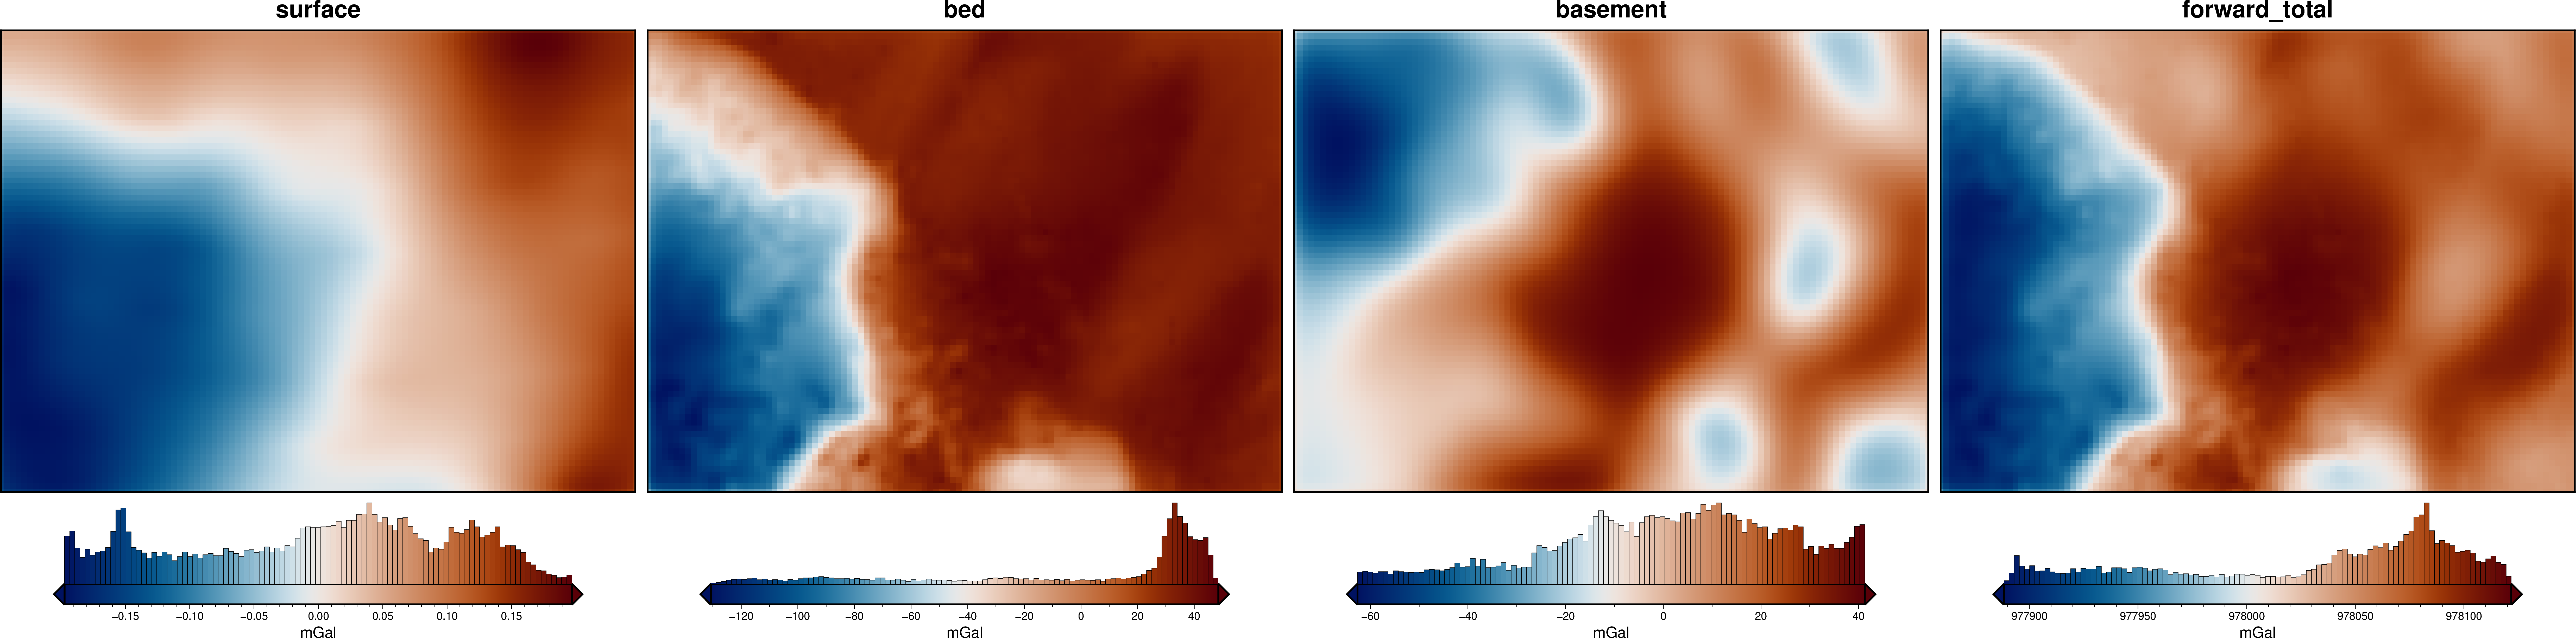

In [8]:
forward_grids, forward_df = inv_utils.forward_grav_of_prismlayer(
    [
        surface_prisms,
        bed_prisms,
        basement_prisms,
    ],
    observation_points,
    plot=True,
    names=[
        "surface",
        "bed",
        "basement",
    ],
    remove_mean=False,
    DC_shift=978032,
    progressbar=True,
)

In [9]:
# save to a .zarr file
forward_grids.to_zarr(
    "../synthetic_data/Ross_Sea_forward_grav.zarr",
    mode="w",
)

In [10]:
# load zarr file
forward_grids = xr.open_zarr("../synthetic_data/Ross_Sea_forward_grav.zarr")
forward_grids

<xarray.Dataset>
Dimensions:        (northing: 81, easting: 111)
Coordinates:
  * easting        (easting) float64 -3e+05 -2.95e+05 ... 2.45e+05 2.5e+05
  * northing       (northing) float64 -1.9e+06 -1.895e+06 ... -1.5e+06
Data variables:
    basement       (northing, easting) float64 dask.array<chunksize=(81, 111), meta=np.ndarray>
    bed            (northing, easting) float64 dask.array<chunksize=(81, 111), meta=np.ndarray>
    forward_total  (northing, easting) float64 dask.array<chunksize=(81, 111), meta=np.ndarray>
    surface        (northing, easting) float64 dask.array<chunksize=(81, 111), meta=np.ndarray>
    upward         (northing, easting) float64 dask.array<chunksize=(81, 111), meta=np.ndarray>

In [11]:
forward_df = vd.grid_to_table(forward_grids)
forward_df

northing   easting   basement        bed  forward_total   surface  \
0    -1900000.0 -300000.0  -8.259026 -69.871502  977953.723634 -0.145838   
1    -1900000.0 -295000.0 -10.356904 -84.918117  977936.565582 -0.159397   
2    -1900000.0 -290000.0 -10.960204 -88.515571  977932.361072 -0.163153   
3    -1900000.0 -285000.0 -11.067594 -89.625441  977931.141160 -0.165805   
4    -1900000.0 -280000.0 -10.974522 -90.062903  977930.794771 -0.167805   
...         ...       ...        ...        ...            ...       ...   
8986 -1500000.0  230000.0   1.685087  22.793155  978056.627830  0.149589   
8987 -1500000.0  235000.0   3.003687  22.904124  978058.055458  0.147648   
8988 -1500000.0  240000.0   3.900581  22.313636  978058.360442  0.146225   
8989 -1500000.0  245000.0   4.240205  21.920340  978058.304724  0.144179   
8990 -1500000.0  250000.0   3.545385  19.193388  978054.872381  0.133608   

      upward  
0     1000.0  
1     1000.0  
2     1000.0  
3     1000.0  
4     1000.0  
...      ...  
8986  1000.0  
8987  1000.0  
8988  1000.0  
8989  1000.0  
8990  1000.0  

[8991 rows x 7 columns]

#### Save to csv

In [12]:
forward_df.to_csv(
    "../synthetic_data/Ross_Sea_full_res_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

## Sample at constant spacing
make observation points in a lower-resolution grid

In [15]:
# regular grid
coords = vd.grid_coordinates(
    region=inversion_region,
    spacing=sampled_grav_spacing,
    pixel_register=False,
    extra_coords=grav_observation_height,
)

# turn coordinates into dataarray
points = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
)

# turn dataarray into dataframe
df = vd.grid_to_table(points)
df

northing        easting  upward
0   -1900000.0 -300000.000000  1000.0
1   -1900000.0 -280357.142857  1000.0
2   -1900000.0 -260714.285714  1000.0
3   -1900000.0 -241071.428571  1000.0
4   -1900000.0 -221428.571429  1000.0
..         ...            ...     ...
604 -1500000.0  171428.571429  1000.0
605 -1500000.0  191071.428571  1000.0
606 -1500000.0  210714.285714  1000.0
607 -1500000.0  230357.142857  1000.0
608 -1500000.0  250000.000000  1000.0

[609 rows x 3 columns]

### sample grid

In [16]:
# sample the data at the observation points
grav_sampled = profile.sample_grids(
    df, forward_grids.forward_total, "Gobs", coord_names=("easting", "northing")
)
grav_sampled

northing        easting  upward           Gobs
0   -1900000.0 -300000.000000  1000.0  977953.750000
1   -1900000.0 -280357.142857  1000.0  977930.824902
2   -1900000.0 -260714.285714  1000.0  977932.131013
3   -1900000.0 -241071.428571  1000.0  977932.077282
4   -1900000.0 -221428.571429  1000.0  977949.151239
..         ...            ...     ...            ...
604 -1500000.0  171428.571429  1000.0  978039.819971
605 -1500000.0  191071.428571  1000.0  978042.316452
606 -1500000.0  210714.285714  1000.0  978049.194971
607 -1500000.0  230357.142857  1000.0  978056.745741
608 -1500000.0  250000.000000  1000.0  978054.875000

[609 rows x 4 columns]

### grid

In [17]:
Gobs_sampled = pygmt.surface(
    data=grav_sampled[["easting", "northing", "Gobs"]],
    region=inversion_region,
    spacing=sampled_grav_spacing,
    registration=registration,
    T=0.25,
    verbose="q",
)

### plot

returning original grid
returning original grid


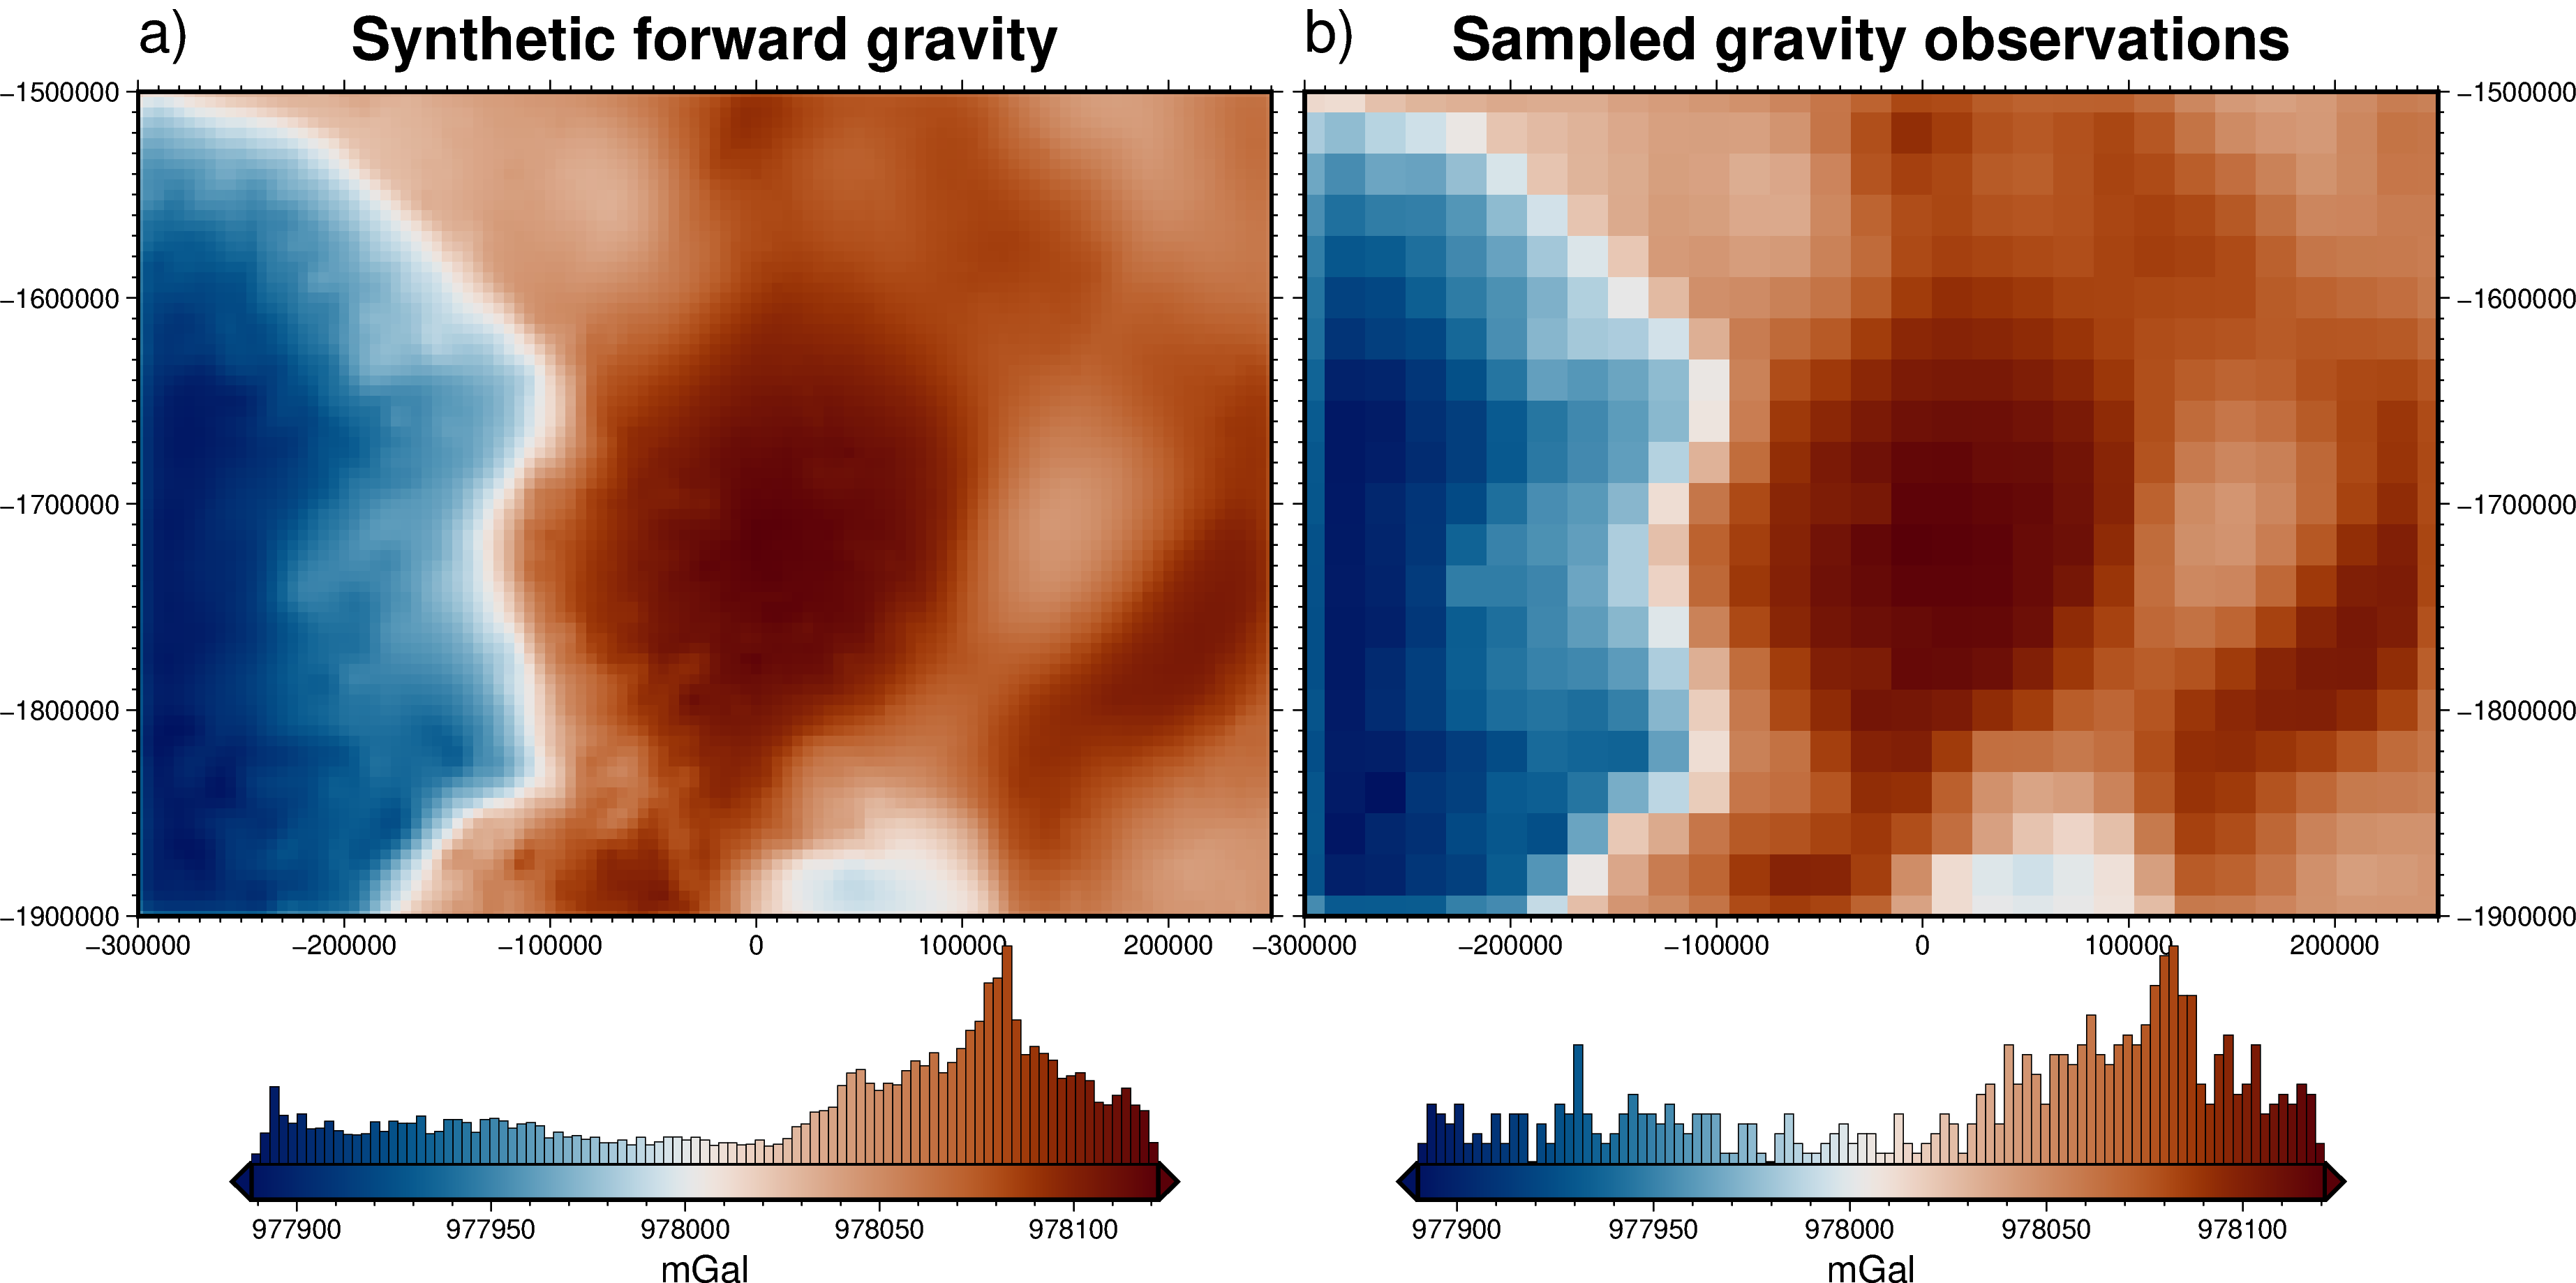

In [19]:
# plot the synthetic gravity anomaly grid
fig = maps.plot_grd(
    forward_grids.forward_total,
    region=inversion_region,
    fig_height=10,
    cmap="vik",
    title="Synthetic forward gravity",
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
    # show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    grd2_cpt=True,
)
fig.text(
    position="TL",
    text="a)",
    fill="white",
    font="20p,Helvetica,black",
    offset="j0/-1",
    clearance="+tO",
    no_clip=True,
)
# plot observation points
# fig.plot(grav[["x", "y"]], style="c.04c", color="black")

# plot the synthetic observed gravity grid
fig = maps.plot_grd(
    Gobs_sampled,
    region=inversion_region,
    fig_height=10,
    cmap="vik",
    title="Sampled gravity observations",
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    # show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    grd2_cpt=True,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position="TL",
    text="b)",
    fill="white",
    font="20p,Helvetica,black",
    offset="j0/-1",
    clearance="+tO",
    no_clip=True,
)
fig.show()

### save to a csv

In [20]:
grav_sampled.to_csv(
    "../synthetic_data/Ross_Sea_sampled_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

## Simulate airborne survey

### create observation points

In [21]:
# irregular grid
# offset so doesn't line up with anomalies
offset = 7e3
# simulate N-S tie lines
x = np.arange(inversion_region[0] + offset, inversion_region[1], 50e3)
y = np.arange(inversion_region[2], inversion_region[3], airborne_grav_spacing)
# remove the 3rd and 9th N-S lines
x = np.delete(x, 2)
x = np.delete(x, 8)

coords = np.meshgrid(x, y)
# turn coordinates into dataarray
ties = vd.make_xarray_grid(
    coords,
    data=np.ones_like(coords[0]) * 1e3,
    data_names="upward",
    dims=("northing", "easting"),
)
# turn dataarray into dataframe
df_ties = vd.grid_to_table(ties)

# simulate E-W flight lines
x = np.arange(inversion_region[0], inversion_region[1], airborne_grav_spacing)
y = np.arange(inversion_region[2] + offset, inversion_region[3], 15e3)
# remove a few E-W lines, starting from bottom
y = np.delete(y, [3, 8, 17])

coords = np.meshgrid(x, y)
# turn coordinates into dataarray
lines = vd.make_xarray_grid(
    coords,
    data=np.ones_like(coords[0]) * 1e3,
    data_names="upward",
    dims=("northing", "easting"),
)
# turn dataarray into dataframe
df_lines = vd.grid_to_table(lines)

# merge dataframes
df = pd.concat([df_ties, df_lines])
df

northing   easting  upward
0     -1900000.0 -293000.0  1000.0
1     -1900000.0 -243000.0  1000.0
2     -1900000.0 -143000.0  1000.0
3     -1900000.0  -93000.0  1000.0
4     -1900000.0  -43000.0  1000.0
...          ...       ...     ...
13195 -1503000.0  245000.0  1000.0
13196 -1503000.0  246000.0  1000.0
13197 -1503000.0  247000.0  1000.0
13198 -1503000.0  248000.0  1000.0
13199 -1503000.0  249000.0  1000.0

[16800 rows x 3 columns]

### sample grid

In [22]:
# sample the noisy data at the observation points
grav_survey = profile.sample_grids(
    df, forward_grids.forward_total, "Gobs", coord_names=("easting", "northing")
)
grav_survey

northing   easting  upward           Gobs
0     -1900000.0 -293000.0  1000.0  977933.810500
1     -1900000.0 -243000.0  1000.0  977931.496000
2     -1900000.0 -143000.0  1000.0  978044.832500
3     -1900000.0  -93000.0  1000.0  978076.579000
4     -1900000.0  -43000.0  1000.0  978083.104000
...          ...       ...     ...            ...
13195 -1503000.0  245000.0  1000.0  978061.525500
13196 -1503000.0  246000.0  1000.0  978060.936088
13197 -1503000.0  247000.0  1000.0  978060.108884
13198 -1503000.0  248000.0  1000.0  978059.181336
13199 -1503000.0  249000.0  1000.0  978058.290892

[16800 rows x 4 columns]

### grid

In [23]:
Gobs_survey = pygmt.surface(
    data=grav_survey[["easting", "northing", "Gobs"]],
    region=inversion_region,
    spacing=airborne_grav_spacing,
    registration=registration,
    T=0.25,
    verbose="q",
)

### plot

returning original grid
returning original grid


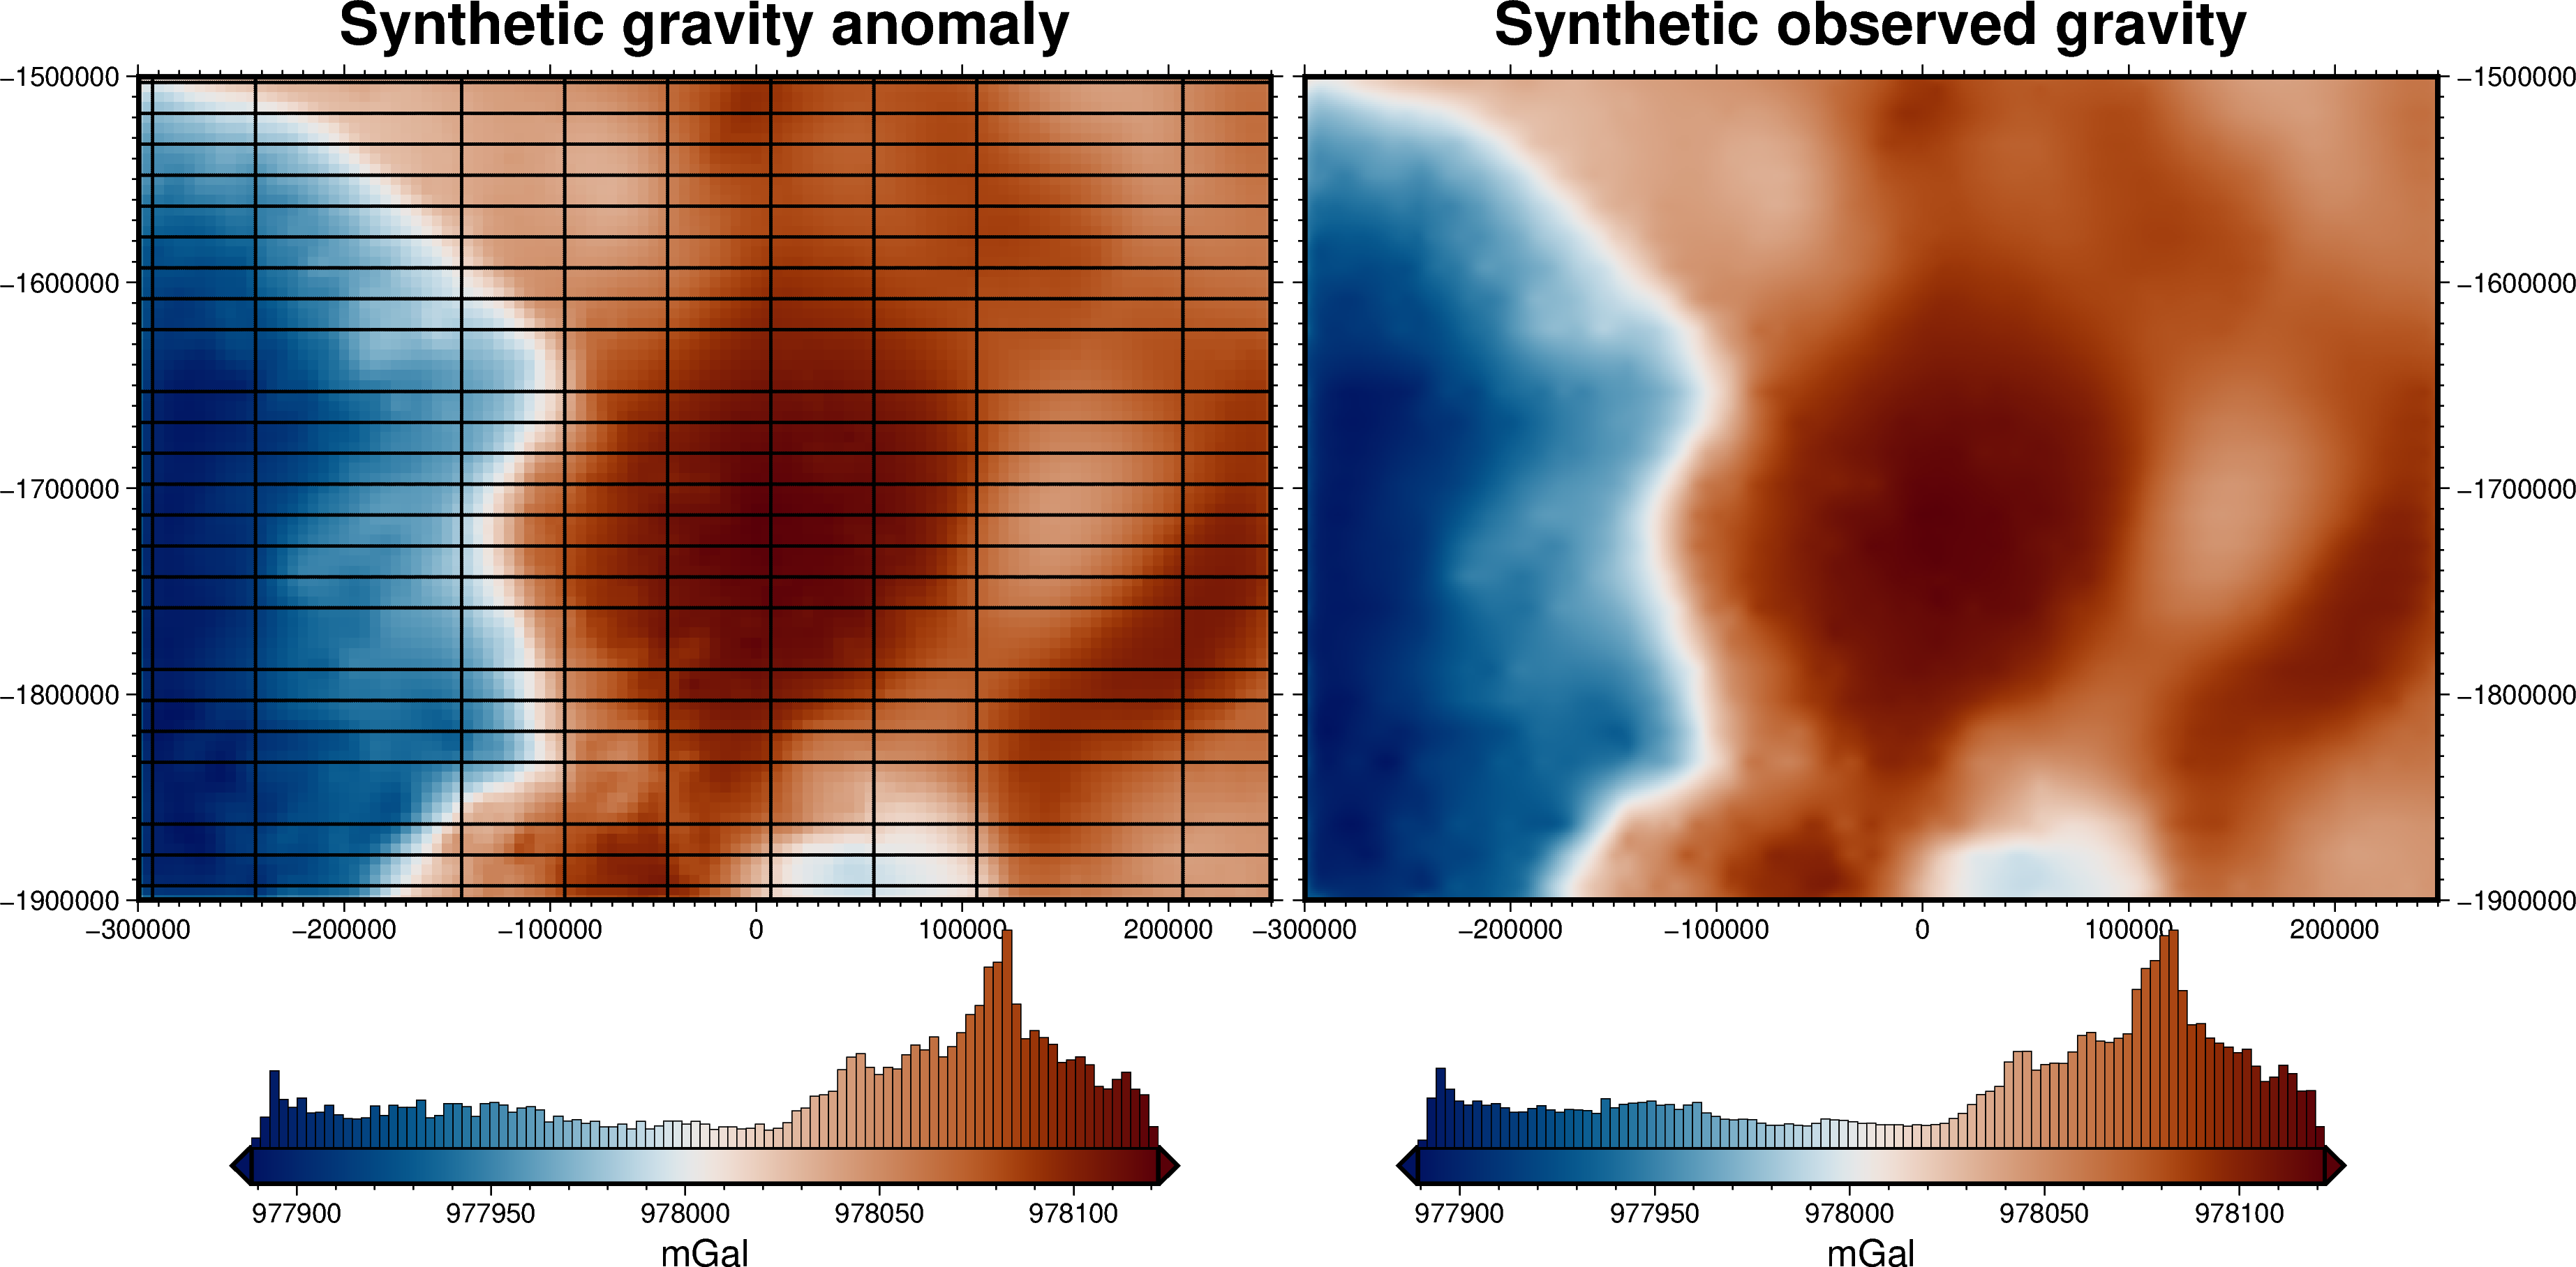

In [24]:
# plot the synthetic gravity anomaly grid
fig = maps.plot_grd(
    forward_grids.forward_total,
    region=buffer_region,
    fig_height=10,
    cmap="vik",
    title="Synthetic gravity anomaly",
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    grd2_cpt=True,
)

# plot observation points
fig.plot(grav_survey[["easting", "northing"]], style="c.04c", color="black")

# plot the synthetic observed gravity grid
fig = maps.plot_grd(
    Gobs_survey,
    region=buffer_region,
    fig_height=10,
    cmap="vik",
    title="Synthetic observed gravity",
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    grd2_cpt=True,
    fig=fig,
    origin_shift="xshift",
)

fig.show()

grid spacings don't match, using smaller spacing (1000.0m).
Warning, requested spacing (1000.0) is smaller than the original  (5000.0).
returning original grid
returning original grid


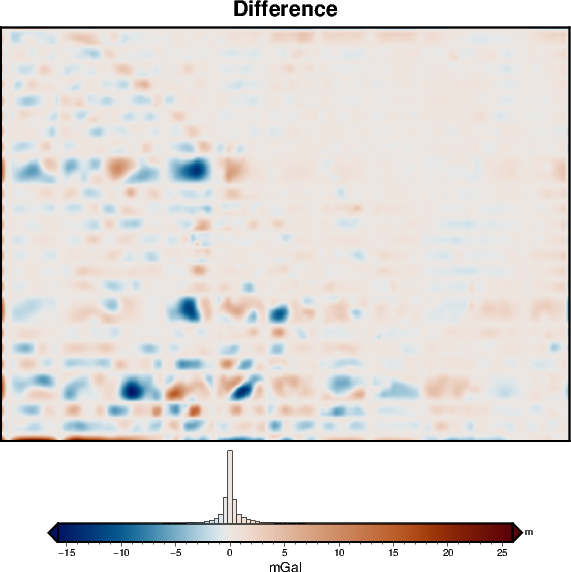

In [25]:
grids = utils.grd_compare(
    forward_grids.forward_total,
    Gobs_survey,
    plot=False,
)

maps.plot_grd(
    grids[0],
    cmap="vik+h0",
    title="Difference",
    cbar_unit="m",
    cbar_label="mGal",
    inset=False,
    hist=True,
)

### save to a csv

In [26]:
grav_survey.to_csv(
    "../synthetic_data/Ross_Sea_airborne_survey_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

# Create low-resolution bathymetry
## random constraint points

In [27]:
x_range = abs(inversion_region[0] - inversion_region[1]) / 1000
y_range = abs(inversion_region[2] - inversion_region[3]) / 1000
inversion_area = x_range * y_range

print(f"inversion region: {inversion_area} km\u00b2")

inversion region: 220000.0 km²


In [28]:
# num_constraints = 30
# const_density = inversion_area / num_constraints

const_density = 2000
num_constraints = int(inversion_area / const_density)
print(f"number of constraints: {num_constraints}")
print(f"constraint density: 1 constraint per {const_density} km\u00b2")

number of constraints: 110
constraint density: 1 constraint per 2000 km²


In [29]:
# compared to Ross Ice Shelf
print(f"Ross Ice Shelf constraint density: 1 constraint per {487000 / 224} km\u00b2")

Ross Ice Shelf constraint density: 1 constraint per 2174.1071428571427 km²


In [30]:
coords = vd.scatter_points(
    region=inversion_region, size=num_constraints, random_state=2
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

In [31]:
constraint_points = profile.sample_grids(
    constraint_points, bed, "upward", coord_names=("easting", "northing")
)

lowres_bed = pygmt.surface(
    data=constraint_points,
    region=buffer_region,
    spacing=layer_spacing,
    registration=registration,
    T=0.35,
    verbose="q",
).rename({"x": "easting", "y": "northing"})

constraint_points

easting      northing       upward
0    -60202.803822 -1.794489e+06  -672.470024
1   -285740.572495 -1.534434e+06 -1704.880401
2      2314.362833 -1.732106e+06  -288.343065
3    -60572.684060 -1.683923e+06  -472.233651
4    -68797.708852 -1.656623e+06  -477.404576
..             ...           ...          ...
105   -1160.123179 -1.553047e+06  -616.497600
106 -178539.146716 -1.583068e+06 -1537.094753
107  205152.255624 -1.760399e+06  -364.721091
108   25646.517717 -1.672344e+06  -385.185656
109 -109569.149800 -1.577947e+06  -644.615495

[110 rows x 3 columns]

In [32]:
output = lowres_bed.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/Ross_Sea_lowres_bed.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

In [33]:
lowres_bed = xr.open_zarr("../synthetic_data/Ross_Sea_lowres_bed.zarr").z
utils.get_grid_info(lowres_bed)

(5000.0,
 [-300000.0, 250000.0, -1900000.0, -1500000.0],
 -3885.21142578,
 -305.317504883,
 'g')

In [34]:
constraint_points.to_csv(
    "../synthetic_data/Ross_Sea_synthetic_constraints.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


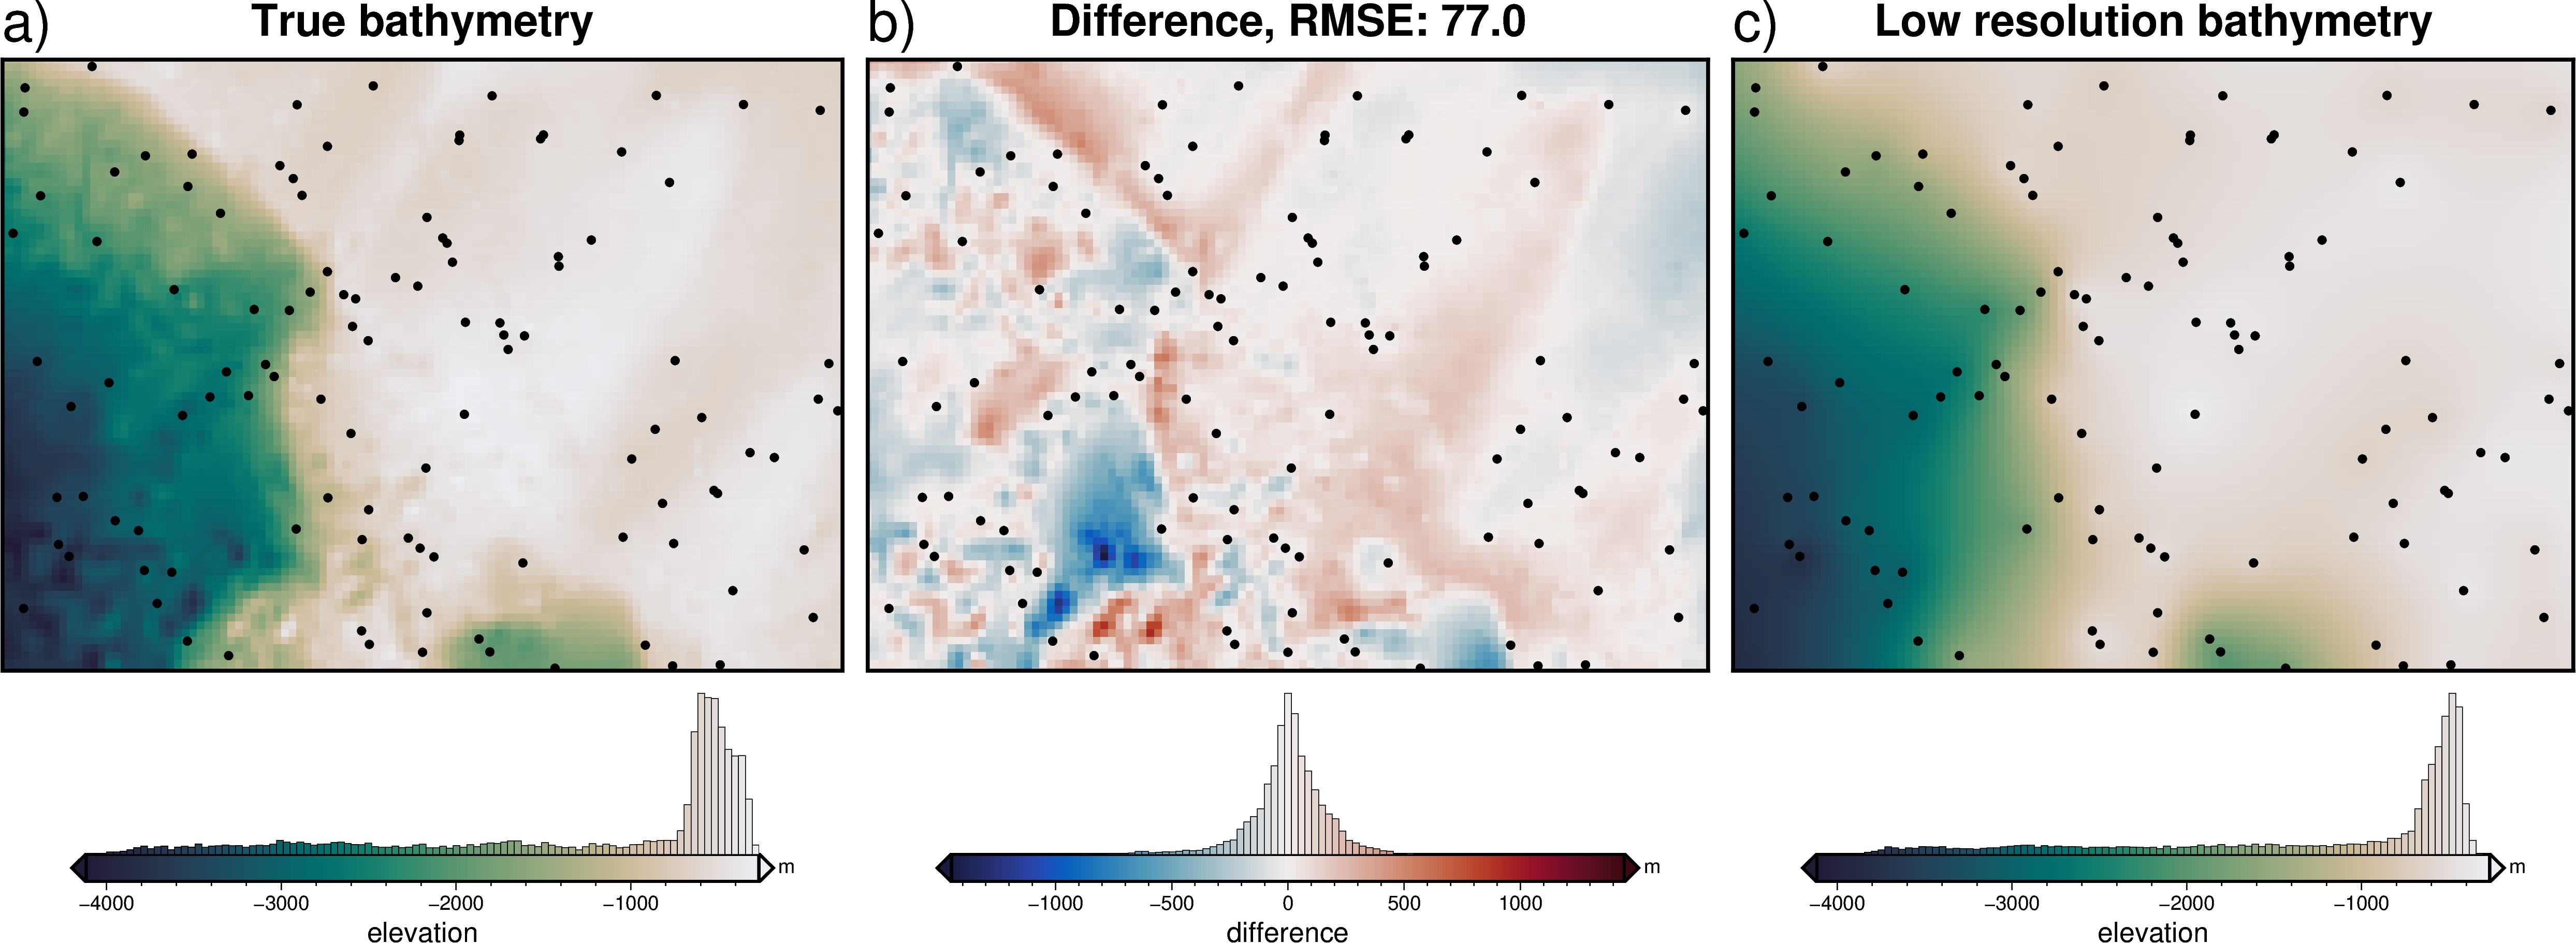

In [35]:
grids = utils.grd_compare(
    bed,
    lowres_bed,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    grid1_name="True bathymetry",
    grid2_name="Low resolution bathymetry",
    title="Difference",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c.15c",
    show_region=inversion_region,
    inset=False,
    hist=True,
    subplot_labels=True,
)